# Sklearn regression pipeline (Phase 1)

In this phase, we perform a grid search for whether feature engineering and feature selection should be included in the model. We assume non-regularized models for now and consider regularization in Phase 2.

In [10]:
%config Completer.use_jedi=False

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from pathlib import Path
import pickle 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from data import train, validation
from data import X, y, numerical, categorical
from utils import StandardizedGridSearchCV

In [12]:
train.head()

,attribute2,clickVolume,avgOriginalUnitPrice,avgFinalUnitPrice,ma14SalesVolume,meanAge,gender,meanEducation,maritalStatus,plus,...,brandID_33,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,attribute1_2,attribute1_3,attribute1_4
1404,4.850075,3.082306,4.281904,3.791205,6.480146,7.813408,1.380382,11.580054,2.201123,1.650476,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2184,2.910045,0.094506,1.709888,1.637009,0.059201,7.600842,0.000000,10.896544,1.410243,1.856786,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
796,4.850075,0.217541,0.994800,1.103595,0.193577,7.016162,0.849466,11.865126,0.987170,0.866500,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
25,3.880060,0.327738,1.566200,1.306937,0.509315,6.876952,0.000000,10.805739,1.645284,1.624688,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1745,4.850075,0.389791,2.506703,2.351882,0.265934,8.667627,1.162427,11.653248,3.117380,1.476989,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Feature Engineering + Feature Selection
We first use a grid search to consider:
- Power transformations on the response variable
- Adding polynomial terms for predictors 
- Adding interaction terms for predictors
Within each parameter combination, models additionally undergo a backwards variable selection procedure using validation MSE as a metric. 

In [13]:
from sklearn.pipeline import Pipeline

pipeline = dict()
param_grid = dict()

## Feature engineering (Preprocessing)

We create a preprocessing pipeline (`preprocessor`) to later embed into the overall model pipeline. The preprocessor is kept seperate so that it can also be transferred to other models.

We consider optionally adding polynomial and interaction terms of up to degree 3 (`PolynomialFeatures`), one of the feature selection steps outlined above, as well as a power transformation (`PowerTransformer`) to normalize the response.

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures

pipeline['preprocessing'] = Pipeline([
    ('categorical', 'passthrough'),
    ('numerical', ColumnTransformer([
        ('poly', PolynomialFeatures(), numerical),
    ])),
    ('drop', VarianceThreshold()),
])

param_grid['preprocessing'] = {
    'numerical__poly': [
        PolynomialFeatures(degree=3, include_bias=False),
        PolynomialFeatures(degree=2, include_bias=False),
        'passthrough'
    ],
}

## Feature selection

1. RFE (Recursive feature Elimination) removes variables with low coefficients. 
  - O\[k\] at each step, k is number of cross validation folds. 
  - May have trouble finding global optimum. 
  - *Guaranteed* local optimum.

2. Sequential feature selection removes variables by test MSE.
  - O\[kn\] at each step, k is number of cross validation folds, n is number of features.
  - Intuitively feels more likely to find global optimum.
  - However, cannot even guarantee a local optimum without some manual searching.


In [15]:
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

pipeline['dim_reduction'] = Pipeline([
    ('method', 'passthrough'),
])

param_grid['dim_reduction'] = {
    'method': [
        # SequentialFeatureSelector(
        #     estimator = LinearRegression(),
        #     direction = 'backward',
        #     scoring = 'neg_mean_squared_error',
        #     n_jobs=-1,
        # ),
        RFECV(
            estimator = LinearRegression(),
            scoring = 'neg_mean_squared_error',
            # n_jobs=-1,
        ),
        'passthrough',
    ],
}


## Candidate models

Having previously noted the non-normal distribution of the response, we consider a standard OLS model with an optional power transformation to normalize the response. We also consider generalized linear models as they have empirically performed well with non-normally distributed data.

In [16]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, TweedieRegressor, LogisticRegression
from sklearn.preprocessing import PowerTransformer

pipeline['model_fitting'] = Pipeline([
    ('method', 'passthrough'), # Set in param grid
])

param_grid['model_fitting'] = {
    'method': [
        TweedieRegressor(power=1, max_iter=10000), # Poisson GLM
        TweedieRegressor(power=2, max_iter=10000), # Gamma GLM
        TweedieRegressor(power=3, max_iter=10000), # Inverse Gaussian GLM
        TransformedTargetRegressor(
            regressor = LinearRegression(),
            transformer = PowerTransformer(),
        ),
        LinearRegression(),
    ]
}

## Final Pipeline

In [19]:
from sklearn.model_selection import GridSearchCV

search = StandardizedGridSearchCV(
    estimator = Pipeline([
        (name, pipe) 
        for name, pipe in pipeline.items()
    ]),
    param_grid = {
        f'{name}__{param}': value 
        for name, subgrid in param_grid.items()
        for param, value in subgrid.items()
    },
)

print(search)

Pipeline Structure
--------------------------------------------------------------------------------
Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('categorical', 'passthrough'),
                                 ('numerical',
                                  ColumnTransformer(transformers=[('poly',
                                                                   PolynomialFeatures(),
                                                                   ['attribute2',
                                                                    'clickVolume',
                                                                    'avgOriginalUnitPrice',
                                                                    'avgFinalUnitPrice',
                                                                    'ma14SalesVolume',
                                                                    'meanAge',
                                                                    'gender',


In [35]:
search.fit(train[X], train[y])
search.results

Fitting 10 folds for each of 30 candidates, totalling 300 fits
/home/mitchellkwong/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-5.01774450e+12 -5.64248645e+03 -1.11534147e+04 -3.11000484e+09
 -3.83424059e+04 -1.75206518e+04             nan             nan
             nan             nan -1.47630494e+05 -1.55648548e+10
 -4.89880839e+03 -2.61255390e+03 -3.58855608e+03 -1.02351469e+04
 -6.31991846e+03 -1.17293868e+04 -1.02351469e+04 -1.88023515e+04
 -1.67431361e+04             nan             nan             nan
 -1.74379219e+21 -4.70598393e+04 -1.62763729e+10 -7.44792268e+04
 -2.66152225e+03 -3.58532146e+03]
  warnings.warn(
/home/mitchellkwong/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [-8.71943220e+03 -3.11008471e+03 -7.62986421e+03 -4.32887007e+11
 -3.62986199e+04 -1.69043250e+04             nan 

TweedieRegressor(max_iter=10000, power=1)          PolynomialFeatures(degree=3, include_bias=False)         0.000000   
RFECV(estimator=LinearRegression(), scoring='ne... TweedieRegressor(max_iter=10000, power=1)          passthrough                                              0.288582   
passthrough                                        TweedieRegressor(max_iter=10000, power=1)          passthrough                                              0.293727   
                                                   TweedieRegressor(max_iter=10000, power=2)          passthrough                                             -0.498744   
RFECV(estimator=LinearRegression(), scoring='ne... TweedieRegressor(max_iter=10000, power=2)          passthrough                                             -0.595516   
passthrough                                        TweedieRegressor(max_iter=10000, power=2)          PolynomialFeatures(include_bias=False)                  -0.906432   
RFECV(estimator=LinearRegression(), scoring='ne... TweedieRegressor(max_iter=10000, power=2)          PolynomialFeatures(include_bias=False)                  -3.655359   
passthrough                                        TransformedTargetRegressor(regressor=LinearRegr... PolynomialFeatures(include_bias=False)                  -0.473024   
                                                   LinearRegression()                                 PolynomialFeatures(degree=3, include_bias=False)         0.935434   
RFECV(estimator=LinearRegression(), scoring='ne... TransformedTargetRegressor(regressor=LinearRegr... PolynomialFeatures(include_bias=False)                  -6.307089   
                                                   TweedieRegressor(max_iter=10000, power=2)          PolynomialFeatures(degree=3, include_bias=False)       -76.918545   
                                                   TransformedTargetRegressor(regressor=LinearRegr... passthrough                                        -156926.815320   
passthrough                                        TransformedTargetRegressor(regressor=LinearRegr... passthrough                                        -147104.510957   
RFECV(estimator=LinearRegression(), scoring='ne... TweedieRegressor(max_iter=10000, power=1)          PolynomialFeatures(degree=3, include_bias=False)         0.686617   
passthrough                                        TransformedTargetRegressor(regressor=LinearRegr... PolynomialFeatures(degree=3, include_bias=False)         0.861150   
RFECV(estimator=LinearRegression(), scoring='ne... TransformedTargetRegressor(regressor=LinearRegr... PolynomialFeatures(degree=3, include_bias=False)       -55.641818   
                                                   TweedieRegressor(max_iter=10000, power=3)          passthrough                                                   NaN   
                                                                                                      PolynomialFeatures(include_bias=False)                        NaN   
                                                                                                      PolynomialFeatures(degree=3, include_bias=False)              NaN   
passthrough                                        TweedieRegressor(max_iter=10000, power=3)          PolynomialFeatures(degree=3, include_bias=False)              NaN   
                                                                                                      PolynomialFeatures(include_bias=False)                        NaN   
                                                                                                      passthrough                                                   NaN   

                                                                                                                                                        split9_train_r2  \
dim_reduction__method                              model_fitting__method                              preprocessing__

## Save results

In [37]:
search.save('models/regression.p')

# Simple Analysis

## Train test errors across models

In [38]:
search.results

TweedieRegressor(max_iter=10000, power=1)          PolynomialFeatures(degree=3, include_bias=False)         0.000000   
RFECV(estimator=LinearRegression(), scoring='ne... TweedieRegressor(max_iter=10000, power=1)          passthrough                                              0.288582   
passthrough                                        TweedieRegressor(max_iter=10000, power=1)          passthrough                                              0.293727   
                                                   TweedieRegressor(max_iter=10000, power=2)          passthrough                                             -0.498744   
RFECV(estimator=LinearRegression(), scoring='ne... TweedieRegressor(max_iter=10000, power=2)          passthrough                                             -0.595516   
passthrough                                        TweedieRegressor(max_iter=10000, power=2)          PolynomialFeatures(include_bias=False)                  -0.906432   
RFECV(estimator=LinearRegression(), scoring='ne... TweedieRegressor(max_iter=10000, power=2)          PolynomialFeatures(include_bias=False)                  -3.655359   
passthrough                                        TransformedTargetRegressor(regressor=LinearRegr... PolynomialFeatures(include_bias=False)                  -0.473024   
                                                   LinearRegression()                                 PolynomialFeatures(degree=3, include_bias=False)         0.935434   
RFECV(estimator=LinearRegression(), scoring='ne... TransformedTargetRegressor(regressor=LinearRegr... PolynomialFeatures(include_bias=False)                  -6.307089   
                                                   TweedieRegressor(max_iter=10000, power=2)          PolynomialFeatures(degree=3, include_bias=False)       -76.918545   
                                                   TransformedTargetRegressor(regressor=LinearRegr... passthrough                                        -156926.815320   
passthrough                                        TransformedTargetRegressor(regressor=LinearRegr... passthrough                                        -147104.510957   
RFECV(estimator=LinearRegression(), scoring='ne... TweedieRegressor(max_iter=10000, power=1)          PolynomialFeatures(degree=3, include_bias=False)         0.686617   
passthrough                                        TransformedTargetRegressor(regressor=LinearRegr... PolynomialFeatures(degree=3, include_bias=False)         0.861150   
RFECV(estimator=LinearRegression(), scoring='ne... TransformedTargetRegressor(regressor=LinearRegr... PolynomialFeatures(degree=3, include_bias=False)       -55.641818   
                                                   TweedieRegressor(max_iter=10000, power=3)          passthrough                                                   NaN   
                                                                                                      PolynomialFeatures(include_bias=False)                        NaN   
                                                                                                      PolynomialFeatures(degree=3, include_bias=False)              NaN   
passthrough                                        TweedieRegressor(max_iter=10000, power=3)          PolynomialFeatures(degree=3, include_bias=False)              NaN   
                                                                                                      PolynomialFeatures(include_bias=False)                        NaN   
                                                                                                      passthrough                                                   NaN   

                                                                                                                                                        split9_train_r2  \
dim_reduction__method                              model_fitting__method                              preprocessing__

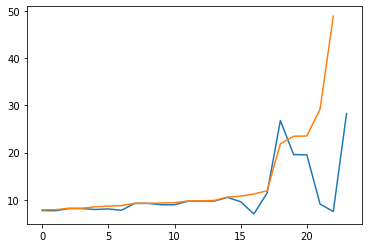

In [39]:
import matplotlib.pyplot as plt

plt.plot(np.log(-search.results['mean_train_neg_mean_squared_error'].values))
plt.plot(np.log(-search.results['mean_test_neg_mean_squared_error'].values))
# , 'mean_test_neg_mean_squared_error']].plot()

## Residual analysis

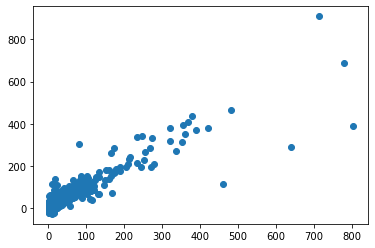

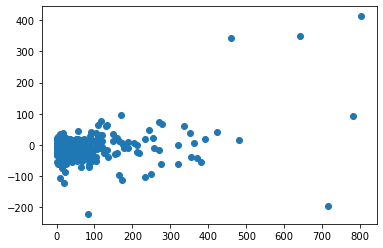

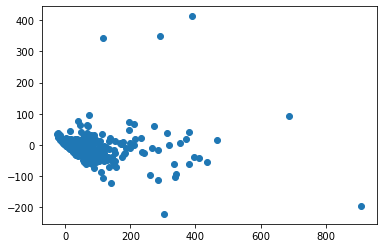

In [40]:
# search.best_estimator_.fit(train[X], train[y])

y_true = validation[y]
y_pred = search.predict(validation[X])
errors = y_true - y_pred

plt.scatter(y_true, y_pred)
plt.show()

plt.scatter(y_true, errors)
plt.show()

plt.scatter(y_pred, errors)
plt.show()

## Validation MSE

In [41]:
np.mean(np.square(errors))

1649.9530101367122